In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import keras
import numpy as np
import os, sys
import pandas as pd
from skimage.external import tifffile
import skimage
import scipy as sp
import scipy.fftpack

#!pip install --user seaborn
#!pip install --user statsmodels

import seaborn as sns
#skimage.__version__

%load_ext autoreload
%autoreload 2
module_folder = os.path.abspath('../src')
#module_folder = 'src/'
if module_folder not in sys.path:
    sys.path.append(module_folder)
import deephydro

data_folder = '../output'
df_pred_name = 'df_pred.csv'
df_pred = pd.read_csv(os.path.join(data_folder, df_pred_name))
df_pred['error'] = df_pred.Q - df_pred.Q_pred

df_pred = df_pred.set_index(df_pred['Time'])
df_pred['month'] = pd.DatetimeIndex(df_pred.index).month
df_pred['year'] = pd.DatetimeIndex(df_pred.index).year
df_pred['day'] = pd.DatetimeIndex(df_pred.index).day
df_pred.head()
#df_pred.tail()

Using TensorFlow backend.


Unnamed: 0        Time      Q      Q_pred  Q_pred_sigma  \
Time                                                                  
1992-05-27       15487  1992-05-27  241.0  264.641479    124.778961   
1992-05-28       15488  1992-05-28  237.0  254.588593    136.049728   
1992-05-29       15489  1992-05-29  237.0  219.143951    123.719574   
1992-05-30       15490  1992-05-30  234.0  249.144928    130.232498   
1992-05-31       15491  1992-05-31  232.0  239.481812    174.397186   

            Q_pred_sigma_epi  Q_pred_sigma_alea      error  month  year  day  
Time                                                                          
1992-05-27         57.506847         110.737312 -23.641479      5  1992   27  
1992-05-28         69.547287         116.930336 -17.588593      5  1992   28  
1992-05-29         65.738037         104.809555  17.856049      5  1992   29  
1992-05-30         54.614456         118.227585 -15.144928      5  1992   30  
1992-05-31        112.488068         133.269714  -7.481812      5  1992   31

In [2]:
model_name = '../output/model_wdb_doy_nobatchnorm_dropout.h5' #model_wdb_log_dropout_batchnorm.h5'

n_frames = 70
Y_MEAN = 715.437
Y_STD  = 426.762

reload_model = True

if reload_model:
    from keras.models import load_model
    from deephydro.metrics import ccc
    model = load_model(model_name, 
               custom_objects={'ccc': ccc})

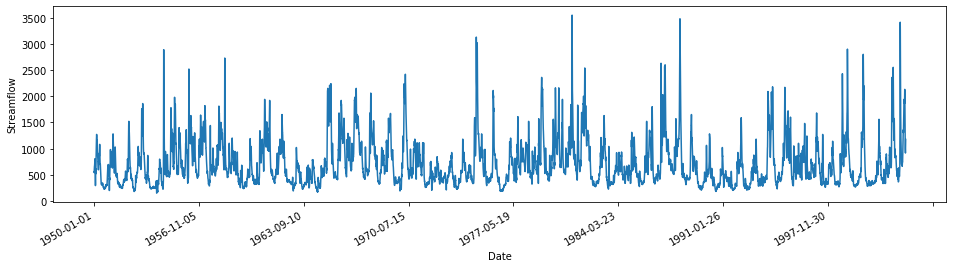

In [3]:
from deephydro import data, visualization

data_folder = '../Data/Npy'
fn_prec = '01_prec_training.npy'
fn_temp = '01_temp_training.npy'
fn_mask = '01_mask.npy'
#data_elev = 'Npy/01_dem.npy'
fn_disc = '01_discharge_training.csv'

df = data.load_csv_data(data_folder=data_folder, filename=fn_disc)
df.head()
visualization.plot_streamflow(df=df)

In [4]:
x_prec = data.load_from_numpy(data_folder, filename=fn_prec)
x_temp = data.load_from_numpy(data_folder, filename=fn_temp)
x_mask = data.load_from_numpy(data_folder, filename=fn_mask)
# x: stack temperature and precipitation data
x = np.stack([x_temp, x_prec], axis=-1)

# x: fractional day of year data
x_doy = df['FDOY'].values

# y: streamflow data
y = df['Q'].values

In [5]:
%%time
import pandas as pd
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

#df_pred = pd.read_csv('../output/df_pred.csv')

gt   = df_pred['Q'].values
pred = df_pred['Q_pred'].values

distance, path = fastdtw(gt, pred, radius=len(gt)//100, dist=euclidean)
print(distance)

91795.86837768555
Wall time: 11.6 s


In [6]:
# 1992-05-28
module_folder = os.path.abspath('../saliency_trials')
#module_folder = 'src/'
if module_folder not in sys.path:
    sys.path.append(module_folder)
from saliency_scr import *

In [7]:
model.layers

In [8]:
realmodel =model.layers[-2]#.summary()

In [9]:
realmodel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             (None, 70, 53, 66, 2 0                                            
__________________________________________________________________________________________________
conv_lst_m2d_17 (ConvLSTM2D)    (None, 70, 26, 32, 3 39296       images[0][0]                     
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 70, 26, 32, 3 0           conv_lst_m2d_17[0][0]            
__________________________________________________________________________________________________
conv_lst_m2d_18 (ConvLSTM2D)    (None, 70, 12, 15, 6 221440      dropout_7[0][0]                  
__________________________________________________________________________________________________
dropout_8 

In [10]:
df_ind = df[df.Time=='1992-05-28'].index[0]
print(df_ind)
x[df_ind]
june10 =np.stack([x[df_ind-n_frames+1:df_ind+1][...,0], x[df_ind-n_frames+1:df_ind+1][...,1]], axis=-1)
june10pred=df_pred[df_pred.Time=='1992-05-28'].Q_pred#predict(model, image=june10, y_mean=Y_MEAN, y_std=Y_STD)

15488


In [11]:
june10.shape, june10pred.shape

((70, 53, 66, 2), (1,))

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             (None, 70, 53, 66, 2 0                                            
__________________________________________________________________________________________________
day_of_year (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
lambda_37 (Lambda)              (None, 70, 53, 66, 2 0           images[0][0]                     
__________________________________________________________________________________________________
lambda_38 (Lambda)              (None, 1)            0           day_of_year[0][0]                
__________________________________________________________________________________________________
lambda_39 

In [28]:
def grad_convlstm(input_model, image,predictions, 
                         #prop_from_layer,
                         prop_to_layer='conv_lst_m2d_2', 
                         normalize=True,abs_w=False,posit_w=False):
    """GradCAM that works for regression output & multidim input for lstm model """
    print(image.shape)
    preprocessed_input = tuple((np.expand_dims(image, 0),np.expand_dims(np.array(0.0004, dtype=float), 0)))
    #preprocessed_input = list([[np.expand_dims(image, 0)],0.4])#load_image(img_path)
    print(preprocessed_input)
    #preprocessed_input2 = np.array(preprocessed_input, dtype=np.float32)
    #print("preprocessed_input.shape ",preprocessed_input.shape)
    #img = np.expand_dims(img, 0)
    #predictions = input_model.predict(preprocessed_input)
    #print(predictions)
    #predicted_class = predictions    
    #realmodel =model.layers[-2]
    prop_from_layer = input_model.layers[-1].name #last dense
    prop_to_layer = input_model.layers[3].name #first convlstm | last = -4
    print("prop_to_layer ",prop_to_layer)
    y_c = input_model.get_layer(prop_from_layer).output#[...,i,j,cls]
    print("y_c: ", y_c)
    conv_output = input_model.get_layer(prop_to_layer).output#[0]
    grads = K.gradients(y_c, conv_output)[0]
    print("grads:", grads)
    print("conv_output.shape, grads.shape: ",conv_output.shape)#, grads.shape)
    """
    Arguments:
    loss: Scalar tensor to minimize.
    variables: List of variables.
    Returns: A gradients tensor."""
    # Normalize if necessary
    # grads = normalize(grads)
    gradient_function = K.function([input_model.get_input_at(0)#[0]#input#get_input_at(0) for models with more inputs than just an image
                                   ], [conv_output, grads])
    """The part of code snippet is as follows -

    final_conv_layer = get_output_layer(model, "conv5_3")
    get_output = K.function([model.layers[0].input], [final_conv_layer.output, model.layers[-1].output])
    [conv_outputs, predictions] = get_output([img])
In this code, there is a model from which "conv5_3" layer is extracted (line 1). 
iN the function K.function(), first argument is input to this model and second is set of 2 
outputs - one for convolution and second for softmax output at the last layer.

As per the Keras/Tensorflow manual, this function runs the computation graph that we have created 
in the code, taking input from the first parameter and extracting the number of outputs as per the
 layers mentioned in the second parameter. Thus, conv_outputs are output of final_conv_layer and 
 predictions are output of model.layers[-1] i.e. last layer of the model.
    """
    output, grads_val = gradient_function(preprocessed_input)#,K.tensor(0.2)])
    print("output, grads_val shapes: ",output.shape, grads_val.shape)
    output, grads_val = output[0, :], grads_val[0, :, :, :]
    print("output, grads_val shapes: ",output.shape, grads_val.shape)
    #print("output[0, :], grads_val[0, :, :, :] ; ",output, grads_val)
    weights = np.mean(grads_val, axis=(0, 1,2))#,3)) # here's the change for our multidim images
    
    if abs_w:
        weights = abs(weights)
    if posit_w:
        weights=np.maximum(weights,0)
        
    cam = np.dot(output, weights) #*abs(grads_val) or max(grads_val,0)
    img_dim = image.shape[1:3] #works for all convlstm layers except the last since it has no temporal dim
    if Debug:
        print("image shape: ", image.shape)
        print("cam shape: ", cam.shape)
        print("img_dim: ",img_dim)
        #print("input_model.output ",input_model.output)#str(K.eval(input_model.output))) #str(y_true.eval())
        #print("y_c: ", y_c)
        #print("conv_output: ",conv_output)
        #print("K.gradients(y_c, conv_output) ", K.gradients(y_c, conv_output))
        #print("K.gradients(y_c, conv_output)[0] aka grads: ", grads)
        #print("gradient_function: ",gradient_function)
        print("output.shape, grads_val.shape: ",output.shape, grads_val.shape)
        #print("output, grads_val: ",output, grads_val)
        print("weights.shape : ",weights.shape)
    # Process CAM
    print("cam T shape: ", cam.T.shape)
    unresizedcam=cam
    cam = cv2.resize(cam.T, img_dim)#[::-1])#, cv2.INTER_LINEAR) #cv2.resize(image,(width,height))
    print("resized cam shape: ", cam.shape)
    cam = np.maximum(cam, 0)
    cam_max = cam.max() 
    if cam_max != 0 and normalize: 
        cam = cam / cam_max
    return cam,predicted_class, unresizedcam
gradcam_june10 =grad_convlstm(realmodel, june10,june10pred, 
                         #prop_from_layer,
                         prop_to_layer='conv_lst_m2d_18', 
                         normalize=False)

(70, 53, 66, 2)
(array([[[[[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         ...,

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]]],


        [[[0., 0.],
          [0., 0.],
          [0., 0.],
          ...,
          [0., 0.],
          [0., 0.],
          [0., 0.]],

       

AttributeError: 'list' object has no attribute 'dtype'

In [19]:
type(realmodel.get_input_at(0)[0])

tensorflow.python.framework.ops.Tensor

## SHAP

In [12]:
# length of image sequence
n_frames = 30
# number of GPUs
n_gpus = 1#4
# adjust this to available GPU memory (VRAM)
batch_size = 92*n_gpus

# use day of year ?
day_of_year = False
# forecasting ?
forecasting = False
# uncertainty estimation ?
uncertainty = False
from deephydro.generator import ImageSequenceGenerator
#generator_train = ImageSequenceGenerator(data=x_train, labels=y_train, batch_size=batch_size, n_frames=n_frames)
generator_test  = ImageSequenceGenerator(data=x_test, labels=y_test, batch_size=batch_size, n_frames=n_frames)

NameError: name 'x_test' is not defined

In [ ]:
# get a batch of images
batch = generator_test.__getitem__(0)
# select a single image
im = batch[0][1]
batch[0].shape

In [ ]:
from deephydro.utils import saliency_map
shap = saliency_map(model, generator=generator_test, 
                    image=im)
print(shap.shape)

In [ ]:
from deephydro.visualization import plot_saliency_map
plot_saliency_map(image=im, shap_values=shap, mask=mask)